In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import cv2

url = 'http://minio-api.kubby.ninja/fix-dive-storage/projects/1234567890/features/features/features.gzip.parquet'

df = pd.read_parquet(url)

df

,frame_index,features
0,0.0,None
1,1.0,None
2,2.0,None
3,3.0,None
4,4.0,b'^\xaeN<Q\x91\xec=\xc1\xfeN>\x00\x00\x00\x00\...
...,...,...
4048,4048.0,None
4049,4049.0,None
4050,4050.0,None
4051,4051.0,b'\x00\x00\x00\x00\xa3\r\x84>Y\x8e\x96?\x00\x0...


In [27]:
# filter out nulls
df = df[df['features'].notnull()]

df['features'] = df['features'].apply(lambda x: np.frombuffer(x, dtype=np.float32))

/tmp/ipykernel_18435/3771824856.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features'] = df['features'].apply(lambda x: np.frombuffer(x, dtype=np.float32))


In [28]:
def kmeans_inertia(scaled_data, k, alpha_k=0.02):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def best_kmeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kmeans_inertia(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

/home/jack/.local/share/virtualenvs/biocam_quality-MTlfE-4o/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jack/.local/share/virtualenvs/biocam_quality-MTlfE-4o/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jack/.local/share/virtualenvs/biocam_quality-MTlfE-4o/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jack/.local/share/virtualenvs/biocam_quality-MTlfE-4o/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `

best k: 7


/tmp/ipykernel_18435/330222981.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = model.labels_


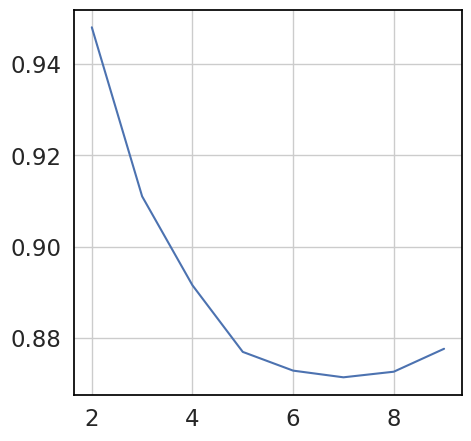

In [29]:
x = np.concatenate(df['features'].values, axis=0).reshape(-1, 2048)

scaler = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=150))
])

xt = scaler.fit_transform(x)

best_k, results = best_kmeans(xt, range(2, 10))

model = KMeans(n_clusters=best_k)

model.fit(xt)

df['cluster'] = model.labels_

print('best k:', best_k)

plt.plot(results)

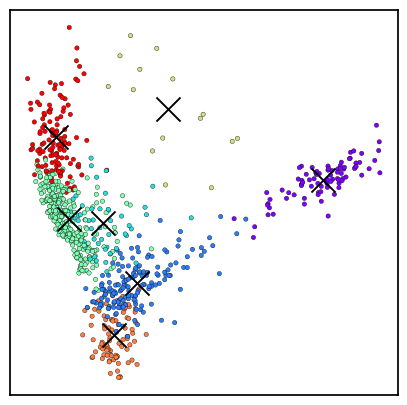

3    290
1    156
6    118
5     89
0     84
2     52
4     15
Name: cluster, dtype: int64

In [30]:
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('rainbow')
sns.set_context('talk')
sns.set(rc={'figure.figsize':(5, 5)})
sns.set(font_scale=1.5)
sns.set_style({'axes.edgecolor': 'black', 'axes.linewidth': 1.0})
sns.set_style({'grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.5})
sns.set_style({'axes.grid': True, 'axes.facecolor': 'white'})

sns.scatterplot(
    x=xt[:, 0],
    y=xt[:, 1],
    hue=model.labels_,
    s=10,
    edgecolor='black',
    palette='rainbow'
)
sns.scatterplot(
    x=model.cluster_centers_[:, 0],
    y=model.cluster_centers_[:, 1],
    color='black',
    s=300,
    marker='x'
)
# remove xticks and yticks
plt.xticks([])
plt.yticks([])

# remove legend
plt.legend([],[], frameon=False)

plt.show()

df['cluster'].value_counts().sort_values(ascending=False)

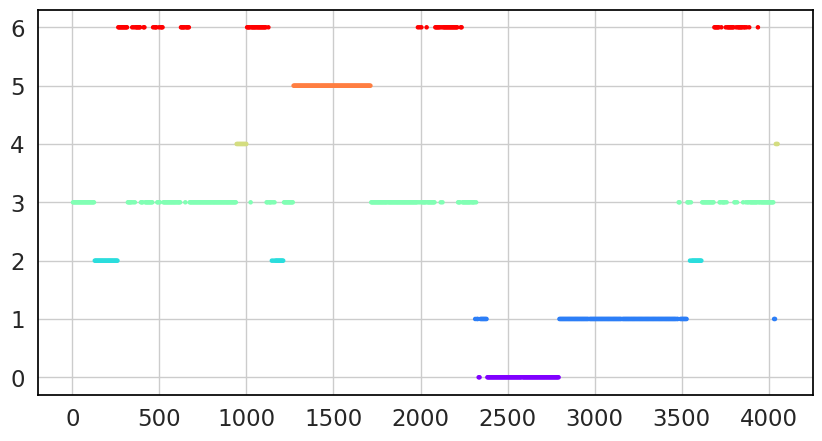

In [31]:
plt.figure(figsize=(10, 5))
plt.scatter(df['frame_index'], df['cluster'], s=5, c=df['cluster'], cmap='rainbow')

In [55]:
df = df.sort_values(by=['frame_index'])

start = 0
end = df['frame_index'].max()
window = 120

clips = []

while start < end - window:
    
    # get frame_index between start and start + window
    
    dfw = df[(df['frame_index'] >= start) & (df['frame_index'] < start + window)]
    
    cluster_counts = dfw['cluster'].value_counts()
    
    for cluster in cluster_counts.index:
        count = cluster_counts[cluster]
        if count > 15:
            clips.append({
                'start': start,
                'end': start + window,
                'cluster': cluster,
                'count': count
            })

    start += (window/2)

dfc = pd.DataFrame(clips, columns=['start', 'end', 'cluster', 'count'])
dfc

,start,end,cluster,count
0,0.0,120.0,3,24
1,120.0,240.0,2,23
2,180.0,300.0,2,16
3,480.0,600.0,3,19
4,540.0,660.0,3,17
5,660.0,780.0,3,22
6,720.0,840.0,3,24
7,780.0,900.0,3,24
8,840.0,960.0,3,20
9,1020.0,1140.0,6,18


In [56]:
dfcg = dfc.groupby('cluster')

for group in dfcg:
    print(group)